In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    print(fname)
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None): #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir
    def download_all(): #@save
        """下载DATA_HUB中的所有文件"""
        for name in DATA_HUB:
            download(name)

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
DATA_HUB['kaggle_house_train'] = ( #@save
DATA_URL + 'kaggle_house_pred_train.csv',
'585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = ( #@save
DATA_URL + 'kaggle_house_pred_test.csv',
'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
#train_data = pd.read_csv(download('kaggle_house_train'))
#test_data =pd.read_csv(download('kaggle_house_test'))

train_data = pd.read_csv('../data/kaggle_house_pred_train_removed.csv')
test_data =pd.read_csv('../data/kaggle_house_pred_test_removed.csv')

In [8]:
print(train_data.shape)
print(test_data.shape)


# Id  MSSubClass  --The building class 
# MSZoning   The general zoning classification
# LotFrontage   Linear feet of street connected to property
# SaleType Type of sale
# SaleCondition   Condition of sale
# SalePrice


print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]])
print(pd.__version__)

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
2.0.3


In [9]:
# remove first column from train and test data, which is no use for model training
#train_data.iloc[:,1:-1] --> remove id and sale price, later saleprice is from train_data
#test_data.iloc[:,1:] --> remove id but keep label

all_features=pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]), axis=0).copy()
#all_features=pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
all_features[-1:]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1458,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [10]:
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [11]:
# # 若无法获得测试数据，则可根据训练数据计算均值和标准差
# all_features.dtypes --> pandas.core.series.Series 
# all_features.dtypes[''].index = Index as following which only is numeric features
# Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
# 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
#  'BsmtUnfSF'],dtype='object')

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# calc mean and std()
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean())/x.std())

# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features]=all_features[numeric_features].fillna(0)


In [12]:
all_features[0:2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal


In [13]:

# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
#all_features = pd.get_dummies(all_features, dummy_na=True)
all_features = pd.get_dummies(all_features, dummy_na=True, dtype =int)
# here features increase from 79 to 330
all_features.shape

(2919, 331)

In [14]:
all_features[0:2]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [15]:
n_train= train_data.shape[0]

train_features= torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

train_labels= torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [16]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
in_features

331

In [17]:

def get_net():
    # V1
    ##net=nn.Sequential(nn.Linear(in_features,1))
    #V2
    net = nn.Sequential(nn.Flatten(),
                        nn.Linear(in_features, 1024),
                        nn.ReLU(),
                        nn.Linear(1024, 512),
                        nn.ReLU(),
                        nn.Linear(512,1))
    #V3
     
    return net

# 为了在取对数时进一步稳定该值，将小于1的值设置为1
def log_rmse(net, features, labels):
    # torch.clamp(x, min, max) --returen x if x in  [1, 'inf'], else return 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    #rmse = torch.sqrt( torch.mean(loss(torch.log(clipped_preds),torch.log(labels))))
    
    return rmse.item()

In [26]:

def train(net, train_features, train_labels, test_features, test_labels,
    num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                    lr = learning_rate,
                                    weight_decay = weight_decay)
    # only for v3 net
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        scheduler.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [19]:
# k-fold cross validation
# 
def get_k_fold_data(k, i, X, y):
    assert k > 1
    #  count of training rows  of each fold 
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        # 1st fold is treated as test set
        if j == i:
            X_valid, y_valid = X_part, y_part
        # fist piece of data of training set
        elif X_train is None:
            X_train, y_train = X_part, y_part
        # concat these data together
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    #  return traing_set, training_label, test_set, test_label
    return X_train, y_train, X_valid, y_valid

In [20]:

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                        weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # why only print i == 0
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                 xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                 legend=['train', 'valid'], yscale='log')
        # d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
        #         xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
        #         legend=[f'train fold {i+1}', f'valid fold {i+1}'], yscale='log')
        print(f'fold {i + 1}，train log rmse {float(train_ls[-1]):f}, 'f'validation log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1，train log rmse 0.127908, validation log rmse 0.149097
fold 2，train log rmse 0.114082, validation log rmse 0.493149


KeyboardInterrupt: 

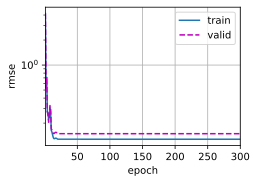

In [27]:
# 5, 100, 10, 0, 64 -> 0.155992
# 5, 100, 30, 0, 64 -> 0.149822
# following are multilayer 1024->1:
# 5, 100, 0.1, 0.35, 256 ->0.141458
# following are multilayer 1024->512->1: 
# 5, 300, 0.5, 1000, 512 -->0.132896
# 
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 0.5, 1000, 512
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
weight_decay, batch_size)
print(f'{k}-fold train: avg train log rmse: {float(train_l):f}, '
f'avg validation log rmse: {float(valid_l):f}')

训练log rmse：0.032580


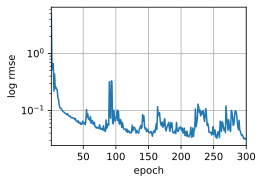

In [22]:
def train_and_pred(train_features, test_features, train_labels, test_data,
num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
    num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
    ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


train_and_pred(train_features, test_features, train_labels, test_data,
num_epochs, lr, weight_decay, batch_size)